open the following link with a new tab


<a href="https://colab.research.google.com/github/nzhinusoftcm/review-on-collaborative-filtering/blob/master/8.Performances_measure.ipynb" target="_blank">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [ ]:
import os

if not (os.path.exists("recsys.zip") or os.path.exists("recsys")):
    !wget https://github.com/nzhinusoftcm/review-on-collaborative-filtering/raw/master/recsys.zip    
    !unzip recsys.zip

### requirements

```
matplotlib==3.2.2
numpy==1.18.1
pandas==1.0.5
python==3.6.10
scikit-learn==0.23.1
scipy==1.5.0
```

In [1]:
from recsys.memories.UserToUser import UserToUser
from recsys.memories.ItemToItem import ItemToItem

from recsys.models.MatrixFactorization import MF
from recsys.models.ExplainableMF import EMF, explainable_score

from recsys.preprocessing import mean_ratings
from recsys.preprocessing import normalized_ratings
from recsys.preprocessing import encode_data
from recsys.preprocessing import split_data
from recsys.preprocessing import rating_matrix
from recsys.preprocessing import get_examples
from recsys.preprocessing import scale_ratings

from recsys.datasets import mlLastedSmall
from recsys.datasets import ml100k
from recsys.datasets import ml1m

from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import os

# 1. Results on the MovieLens Lasted Small Dataset

## 1.1. User-based Collaborative Filtering

In [2]:
# load data
ratings, movies = mlLastedSmall.load()

# get examples as tuples of userids and itemids and labels from normalize ratings
raw_examples, raw_labels = get_examples(ratings, labels_column='rating')

# train test split
(train_examples, test_examples), (train_labels, test_labels) = split_data(examples=raw_examples, labels=raw_labels)

### Evaluation with Cosine Similarity

In [3]:
usertouser = UserToUser(ratings, movies, metric='cosine')
print()
usertouser.evaluate(x_test=test_examples, y_test=test_labels)

Normalize users ratings ...
Create the similarity model ...
Compute nearest neighbors ...
User to user recommendation model created with success ...

Evaluate the model on 10084 test data

MAE : 0.9407768335173052


0.9407768335173052

### Evaluation with the Euclidean Distance

In [4]:
usertouser = UserToUser(ratings, movies, metric='euclidean')
print()
usertouser.evaluate(x_test=test_examples, y_test=test_labels)

Normalize users ratings ...
Create the similarity model ...
Compute nearest neighbors ...
User to user recommendation model created with success ...

Evaluate the model on 10084 test data

MAE : 2.0725184306727424


2.0725184306727424

## 1.2. Item-based Collaborative Filtering

In [2]:
# load data
ratings, movies = mlLastedSmall.load()

# get examples as tuples of userids and itemids and labels from normalize ratings
raw_examples, raw_labels = get_examples(ratings, labels_column='rating')

# train test split
(train_examples, test_examples), (train_labels, test_labels) = split_data(examples=raw_examples, labels=raw_labels)

### Evaluation with the Cosine based similarity

In [3]:
itemtoitem = ItemToItem(ratings, movies, metric='cosine')
print()
itemtoitem.evaluate(x_test=test_examples, y_test=test_labels)

Normalize ratings ...
Create the similarity model ...
Compute nearest neighbors ...
Item to item recommendation model created with success ...

Evaluate the model on 10084 test data ...

MAE : 0.8295861492607545


0.8295861492607545

### Evaluation with the Euclidean distance based similarity

In [4]:
itemtoitem = ItemToItem(ratings, movies, metric='euclidean')
print()
itemtoitem.evaluate(x_test=test_examples, y_test=test_labels)

Normalize ratings ...
Create the similarity model ...
Compute nearest neighbors ...
Item to item recommendation model created with success ...

Evaluate the model on 10084 test data ...

MAE : 3.7233058745678624


3.7233058745678624

## 1.3. Matrix Factorization

In [8]:
# load data
ratings, movies = mlLastedSmall.load()

# normalize ratings by substracting means
normalized_column_name = "norm_rating"
ratings = normalized_ratings(ratings, norm_column=normalized_column_name)

# get examples as tuples of userids and itemids and labels from normalize ratings
raw_examples, raw_labels = get_examples(ratings, labels_column=normalized_column_name)

# train test split
(train_examples, test_examples), (train_labels, test_labels) = split_data(examples=raw_examples, labels=raw_labels)

examples = (train_examples, test_examples)
labels = (train_labels, test_labels)

# encode train and test examples
(X_train, X_test), (y_train, y_test), (uencoder, iencoder) = encode_data( ratings, examples = examples, labels = labels)

Train/Test split 
 90.0 % of training data
 10.0 % of testing data

number of training examples :  (90752, 2)
number of training labels :  (90752,)
number of test examples :  (10084, 2)
number of test labels :  (10084,)


### create and evaluate the model

In [9]:
m = ratings['userid'].nunique()   # total number of users
n = ratings['itemid'].nunique()   # total number of items

# create and train the model
mf = MF(m, n, k=10, alpha=0.01, lamb=1.5)
history = mf.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

Training Matrix Factorization Model ...
k=10 	 alpha=0.01 	 lambda=1.5
epoch 1/10 - loss : 0.775 - val_loss : 0.783
epoch 2/10 - loss : 0.74 - val_loss : 0.746
epoch 3/10 - loss : 0.733 - val_loss : 0.74
epoch 4/10 - loss : 0.731 - val_loss : 0.739
epoch 5/10 - loss : 0.73 - val_loss : 0.738
epoch 6/10 - loss : 0.729 - val_loss : 0.738
epoch 7/10 - loss : 0.729 - val_loss : 0.738
epoch 8/10 - loss : 0.729 - val_loss : 0.738
epoch 9/10 - loss : 0.728 - val_loss : 0.738
epoch 10/10 - loss : 0.728 - val_loss : 0.738


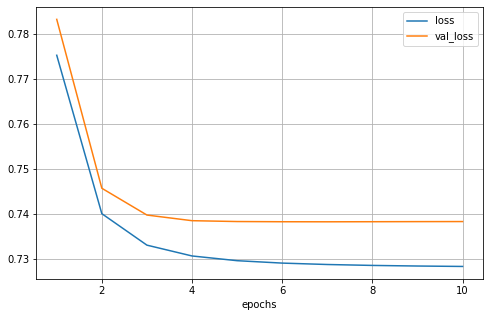

In [10]:
pd.DataFrame(history).plot(x="epochs", figsize=(8, 5))
plt.grid(True)
plt.show()

In [11]:
MF.evaluate(X_test, y_test)

validation error : 0.738


0.7383189025090492

## 1.4. Explainable Matrix Factorization

In [15]:
# load data
ratings, movies = mlLastedSmall.load()

# create the user to user model for similarity measure
usertouser = UserToUser(ratings, movies)

# normalize ratings by substracting means
normalized_column_name = "norm_rating"
ratings = normalized_ratings(ratings, norm_column=normalized_column_name)

# scale rating
scaled_column_name = "scaled_rating"
ratings = scale_ratings(ratings, scaled_column=scaled_column_name)

# get examples as tuples of userids and itemids and labels from normalize ratings
raw_examples, raw_labels = get_examples(ratings, labels_column=normalized_column_name)

# train test split
(train_examples, test_examples), (train_labels, test_labels) = split_data(examples=raw_examples, labels=raw_labels)

examples = (train_examples, test_examples)
labels = (train_labels, test_labels)

# encode train and test examples
(X_train, X_test), (y_train, y_test), (uencoder, iencoder) = encode_data( ratings, examples = examples, labels = labels)

Normalize users ratings ...
Create the similarity model ...
Compute nearest neighbors ...
User to user recommendation model created with success ...


In [16]:
users = sorted(ratings['userid'].unique())
items = sorted(ratings['itemid'].unique())

m = len(users)
n = len(items)

# compute explainable scores
W = explainable_score(usertouser, users, items, uencoder, iencoder)

Compute explainable scores ...


In [19]:
# create, train and evaluate the EMF model
emf = EMF(m, n, W, alpha=0.022, beta=0.4, lamb=0.01, k=10)

history = emf.fit(X_train, y_train, epochs=30, validation_data=(X_test, y_test))

Training EMF
k=10 	 alpha=0.022 	 beta=0.4 	 lambda=0.01
epoch 1/30 - loss : 0.739 - val_loss : 0.796
epoch 2/30 - loss : 0.721 - val_loss : 0.773
epoch 3/30 - loss : 0.715 - val_loss : 0.764
epoch 4/30 - loss : 0.711 - val_loss : 0.759
epoch 5/30 - loss : 0.707 - val_loss : 0.754
epoch 6/30 - loss : 0.701 - val_loss : 0.75
epoch 7/30 - loss : 0.693 - val_loss : 0.744
epoch 8/30 - loss : 0.685 - val_loss : 0.738
epoch 9/30 - loss : 0.677 - val_loss : 0.731
epoch 10/30 - loss : 0.67 - val_loss : 0.726
epoch 11/30 - loss : 0.663 - val_loss : 0.721
epoch 12/30 - loss : 0.658 - val_loss : 0.717
epoch 13/30 - loss : 0.652 - val_loss : 0.714
epoch 14/30 - loss : 0.648 - val_loss : 0.711
epoch 15/30 - loss : 0.644 - val_loss : 0.708
epoch 16/30 - loss : 0.64 - val_loss : 0.706
epoch 17/30 - loss : 0.636 - val_loss : 0.704
epoch 18/30 - loss : 0.633 - val_loss : 0.702
epoch 19/30 - loss : 0.63 - val_loss : 0.701
epoch 20/30 - loss : 0.627 - val_loss : 0.699
epoch 21/30 - loss : 0.624 - val_los

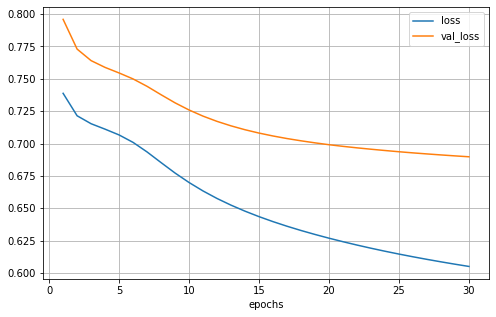

In [20]:
pd.DataFrame(history).plot(x="epochs", figsize=(8, 5))
plt.grid(True)
plt.show()

In [11]:
emf.evaluate(X_test, y_test)

validation error : 0.726


0.7258678071599408

# 2. Results on MovieLens 100k

## 2.1. User-based CF

In [5]:
# load data
ratings, movies = ml100k.load()

# get examples as tuples of userids and itemids and labels from normalize ratings
raw_examples, raw_labels = get_examples(ratings, labels_column='rating')

# train test split
(train_examples, test_examples), (train_labels, test_labels) = split_data(examples=raw_examples, labels=raw_labels)

### Evaluation with cosine similarity

In [6]:
usertouser = UserToUser(ratings, movies, metric='cosine')
print()
usertouser.evaluate(x_test=test_examples, y_test=test_labels)

Normalize users ratings ...
Create the similarity model ...
Compute nearest neighbors ...
User to user recommendation model created with success ...

Evaluate the model on 10000 test data

MAE : 0.8027689454762751


0.8027689454762751

### Evaluation with Euclidean distance

In [7]:
usertouser = UserToUser(ratings, movies, metric='euclidean')
print()
usertouser.evaluate(x_test=test_examples, y_test=test_labels)

Normalize users ratings ...
Create the similarity model ...
Compute nearest neighbors ...
User to user recommendation model created with success ...

Evaluate the model on 10000 test data

MAE : 1.4750535828104068


1.4750535828104068

## 2.2. Item-based CF

In [8]:
# load data
ratings, movies = ml100k.load()

# get examples as tuples of userids and itemids and labels from normalize ratings
raw_examples, raw_labels = get_examples(ratings, labels_column='rating')

# train test split
(train_examples, test_examples), (train_labels, test_labels) = split_data(examples=raw_examples, labels=raw_labels)

### Evaluation with cosine similarity

In [9]:
itemtoitem = ItemToItem(ratings, movies, metric='cosine')
print()
itemtoitem.evaluate(x_test=test_examples, y_test=test_labels)

Normalize ratings ...
Create the similarity model ...
Compute nearest neighbors ...
Item to item recommendation model created with success ...

Evaluate the model on 10000 test data ...

MAE : 0.8420067150336732


0.8420067150336732

### Evaluation with Euclidean distance

In [10]:
itemtoitem = ItemToItem(ratings, movies, metric='euclidean')
print()
itemtoitem.evaluate(x_test=test_examples, y_test=test_labels)

Normalize ratings ...
Create the similarity model ...
Compute nearest neighbors ...
Item to item recommendation model created with success ...

Evaluate the model on 10000 test data ...

MAE : 3.580623631720878


3.580623631720878

## 2.3. Matrix Factorization

In [11]:
# load data
ratings, movies = ml100k.load()

# normalize ratings by substracting means
normalized_column_name = "norm_rating"
ratings = normalized_ratings(ratings, norm_column=normalized_column_name)

# get examples as tuples of userids and itemids and labels from normalize ratings
raw_examples, raw_labels = get_examples(ratings, labels_column=normalized_column_name)

# train test split
(train_examples, test_examples), (train_labels, test_labels) = split_data(examples=raw_examples, labels=raw_labels)

examples = (train_examples, test_examples)
labels = (train_labels, test_labels)

# encode train and test examples
(X_train, X_test), (y_train, y_test), (uencoder, iencoder) = encode_data( ratings, examples = examples, labels = labels)

In [12]:
m = ratings['userid'].nunique()   # total number of users
n = ratings['itemid'].nunique()   # total number of items

# create and train the model
mf = MF(m, n, k=10, alpha=0.015, lamb=2)
mf_hist = mf.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

Training Matrix Factorization Model ...
k=10 	 alpha=0.015 	 lambda=2
epoch 1/10 - loss : 0.83 - val_loss : 0.831
epoch 2/10 - loss : 0.827 - val_loss : 0.828
epoch 3/10 - loss : 0.826 - val_loss : 0.827
epoch 4/10 - loss : 0.826 - val_loss : 0.827
epoch 5/10 - loss : 0.826 - val_loss : 0.827
epoch 6/10 - loss : 0.826 - val_loss : 0.827
epoch 7/10 - loss : 0.826 - val_loss : 0.827
epoch 8/10 - loss : 0.826 - val_loss : 0.827
epoch 9/10 - loss : 0.826 - val_loss : 0.827
epoch 10/10 - loss : 0.826 - val_loss : 0.827


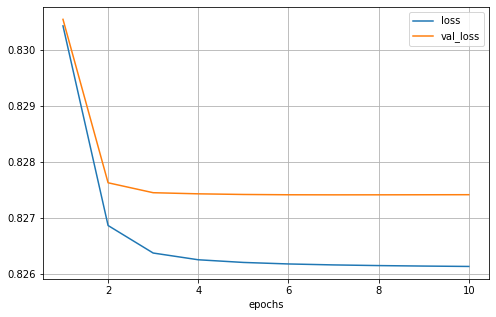

In [13]:
pd.DataFrame(mf_hist).plot(x="epochs", figsize=(8, 5))
plt.grid(True)
plt.show()

In [14]:
mf.evaluate(X_test, y_test)

validation error : 0.827


0.8274155323406809

## 2.4. Explainable Matrix Factorization

In [25]:
# load data
ratings, movies = ml100k.load()

# create the user to user model for similarity measure
usertouser = UserToUser(ratings, movies)

# normalize ratings by substracting means
normalized_column_name = "norm_rating"
ratings = normalized_ratings(ratings, norm_column=normalized_column_name)

# scale rating
scaled_column_name = "scaled_rating"
ratings = scale_ratings(ratings, scaled_column=scaled_column_name)

# get examples as tuples of userids and itemids and labels from normalize ratings
raw_examples, raw_labels = get_examples(ratings, labels_column=normalized_column_name)

# train test split
(train_examples, test_examples), (train_labels, test_labels) = split_data(examples=raw_examples, labels=raw_labels)

examples = (train_examples, test_examples)
labels = (train_labels, test_labels)

# encode train and test examples
(X_train, X_test), (y_train, y_test), (uencoder, iencoder) = encode_data( ratings, examples = examples, labels = labels)

Normalize users ratings ...
Create the similarity model ...
Compute nearest neighbors ...
User to user recommendation model created with success ...
Train/Test split 
90.0 % of training data
10.0 % of testing data

number of training examples :  (90000, 2)
number of training labels :  (90000,)
number of test examples :  (10000, 2)
number of test labels :  (10000,)


In [26]:
users = sorted(ratings['userid'].unique())
items = sorted(ratings['itemid'].unique())

m = len(users)
n = len(items)

# compute explainable scores
W = explainable_score(usertouser, users, items, uencoder, iencoder)

Compute explainable scores ...


In [28]:
# create, train and evaluate the EMF model
emf = EMF(m, n, W, alpha=0.01, beta=0.4, lamb=0.01, k=10)

emf_hist = emf.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

Training EMF
k=10 	 alpha=0.01 	 beta=0.4 	 lambda=0.01
epoch 1/10 - loss : 0.835 - val_loss : 0.888
epoch 2/10 - loss : 0.804 - val_loss : 0.849
epoch 3/10 - loss : 0.796 - val_loss : 0.835
epoch 4/10 - loss : 0.789 - val_loss : 0.824
epoch 5/10 - loss : 0.779 - val_loss : 0.812
epoch 6/10 - loss : 0.768 - val_loss : 0.799
epoch 7/10 - loss : 0.757 - val_loss : 0.787
epoch 8/10 - loss : 0.75 - val_loss : 0.778
epoch 9/10 - loss : 0.744 - val_loss : 0.772
epoch 10/10 - loss : 0.74 - val_loss : 0.767


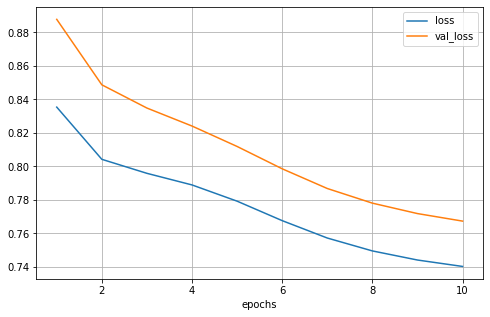

In [29]:
pd.DataFrame(emf_hist).plot(x="epochs", figsize=(8, 5))
plt.grid(True)
plt.show()

In [30]:
emf.evaluate(X_test, y_test)

validation error : 0.767


0.7673674134065074

# 3. Results on MovieLens 1M (ML-1M)

## 3.1. User-based CF

In [2]:
# load data
ratings, movies = ml1m.load()

# get examples as tuples of userids and itemids and labels from normalize ratings
raw_examples, raw_labels = get_examples(ratings, labels_column='rating')

# train test split
(train_examples, test_examples), (train_labels, test_labels) = split_data(examples=raw_examples, labels=raw_labels)

### Cosine similarity

In [3]:
usertouser = UserToUser(ratings, movies, metric='cosine')
print()
usertouser.evaluate(x_test=test_examples, y_test=test_labels)

Normalize users ratings ...
Create the similarity model ...
Compute nearest neighbors ...
User to user recommendation model created with success ...

Evaluate the model on 100021 test data

MAE : 0.8085172593196565


0.8085172593196565

### Euclidean distance

In [4]:
usertouser = UserToUser(ratings, movies, metric='euclidean')
print()
usertouser.evaluate(x_test=test_examples, y_test=test_labels)

Normalize users ratings ...
Create the similarity model ...
Compute nearest neighbors ...
User to user recommendation model created with success ...

Evaluate the model on 100021 test data

MAE : 1.6492639182517055


1.6492639182517055

## 3.2. Item-based CF

### Cosine similarity

In [5]:
itemtoitem = ItemToItem(ratings, movies, metric='cosine')
print()
itemtoitem.evaluate(x_test=test_examples, y_test=test_labels)

Normalize ratings ...
Create the similarity model ...
Compute nearest neighbors ...
Item to item recommendation model created with success ...

Evaluate the model on 100021 test data ...

MAE : 0.9061582112566028


0.9061582112566028

### Euclidean distance

In [6]:
itemtoitem = ItemToItem(ratings, movies, metric='euclidean')
print()
itemtoitem.evaluate(x_test=test_examples, y_test=test_labels)

Normalize ratings ...
Create the similarity model ...
Compute nearest neighbors ...
Item to item recommendation model created with success ...

Evaluate the model on 100021 test data ...

MAE : 6.036554655922524


6.036554655922524

## 3.3. Matrix Factorization

In [7]:
# load data
ratings, movies = ml1m.load()

# normalize ratings by substracting means
normalized_column_name = "norm_rating"
ratings = normalized_ratings(ratings, norm_column=normalized_column_name)

# get examples as tuples of userids and itemids and labels from normalize ratings
raw_examples, raw_labels = get_examples(ratings, labels_column=normalized_column_name)

# train test split
(train_examples, test_examples), (train_labels, test_labels) = split_data(examples=raw_examples, labels=raw_labels)

examples = (train_examples, test_examples)
labels = (train_labels, test_labels)

# encode train and test examples
(X_train, X_test), (y_train, y_test), (uencoder, iencoder) = encode_data( ratings, examples = examples, labels = labels)

In [ ]:
m = ratings['userid'].nunique()   # total number of users
n = ratings['itemid'].nunique()   # total number of items

# create and train the model
mf = MF(m, n, k=10, alpha=0.01, lamb=1.5)
history = mf.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

## 3.4. Explainable Matrix Factorization

In [ ]:
# load data
ratings, movies = ml1m.load()

# create the user to user model for similarity measure
usertouser = UserToUser(ratings, movies)

# normalize ratings by substracting means
normalized_column_name = "norm_rating"
ratings = normalized_ratings(ratings, norm_column=normalized_column_name)

# scale rating
scaled_column_name = "scaled_rating"
ratings = scale_ratings(ratings, scaled_column=scaled_column_name)

# get examples as tuples of userids and itemids and labels from normalize ratings
raw_examples, raw_labels = get_examples(ratings, labels_column=normalized_column_name)

# train test split
(train_examples, test_examples), (train_labels, test_labels) = split_data(examples=raw_examples, labels=raw_labels)

examples = (train_examples, test_examples)
labels = (train_labels, test_labels)

# encode train and test examples
(X_train, X_test), (y_train, y_test), (uencoder, iencoder) = encode_data( ratings, examples = examples, labels = labels)

In [ ]:
users = sorted(ratings['userid'].unique())
items = sorted(ratings['itemid'].unique())

m = len(users)
n = len(items)

# compute explainable scores
W = explainable_score(usertouser, users, items, uencoder, iencoder)

In [ ]:
# create, train and evaluate the EMF model
emf = EMF(m, n, W, alpha=0.01, beta=0.4, lamb=0.01, k=10)

emf_hist = emf.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

## Author

<a href="https://www.linkedin.com/in/carmel-wenga-871876178/">Carmel WENGA</a>, Applied Machine Learning Research Engineer | <a href="https://shoppinglist.cm/fr/">ShoppingList</a>, Nzhinusoft